### Baselines

Notebook for producing baselines in forecasting E. coli levels. This notebook includes a Naive baselins, Exponential Smoothing and the ARIMA model.

In [49]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pmdarima as pm
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm
from utils import *
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from data import *

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:

log_scale_microbial_feats = True

model_name = 'default'
if log_scale_microbial_feats:
    model_name = 'log_scaled_microbial_feats'

data_folder = '../data/cleanedFiles/'
img_path = '../data/output/' + model_name + '/'

target_label = 'ecoli_lab_LAE'

train_start = '2012-04-03' # 5.5 Years of Training
train_end = '2017-10-30'
test_start = '2017-10-31' # 2 Years of Testing
test_end = '2019-10-30'

if not os.path.exists(img_path):
    os.makedirs(img_path)
    os.makedirs(img_path + 'Naive')
    os.makedirs(img_path + 'ARIMA')
    os.makedirs(img_path + 'ExpSmooth')



In [51]:
# Read Data.

df = read_ecoli_lab('ecoli_LAE', log_scale_microbial_feats)

display(df)

,ecoli_lab_LAE
2012-01-02,5.398163
2012-01-03,NaN
2012-01-04,5.707110
2012-01-05,5.739793
2012-01-06,NaN
...,...
2019-12-26,5.017280
2019-12-27,5.081404
2019-12-28,NaN
2019-12-29,NaN


In [52]:
# Remove NaN Values

df = df[~df[target_label].isnull()]

display(df)

,ecoli_lab_LAE
2012-01-02,5.398163
2012-01-04,5.707110
2012-01-05,5.739793
2012-01-09,4.317488
2012-01-11,5.442418
...,...
2019-12-20,5.968708
2019-12-23,4.875197
2019-12-26,5.017280
2019-12-27,5.081404


In [53]:
# Data Split.

df_train = df.loc[(df.index >= train_start) & (df.index <= train_end)]
df_test = df.loc[(df.index >= test_start) & (df.index <= test_end)]

train_dates = df_train.index
test_dates = df_test.index

print(len(train_dates))
print(len(test_dates))

872
341


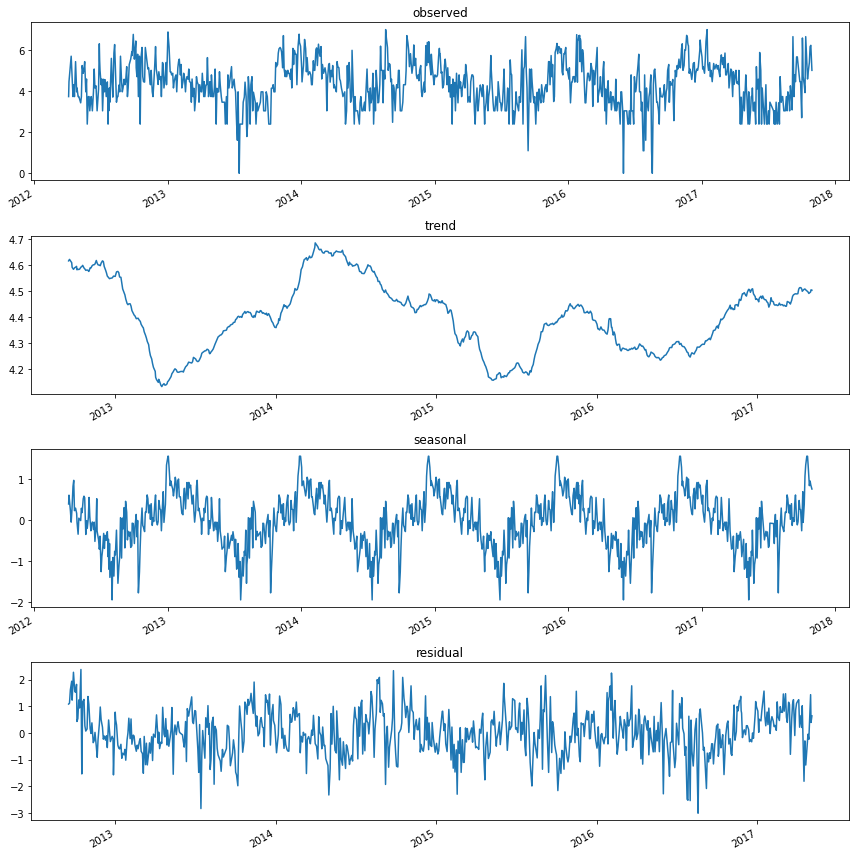

In [54]:
# Decomposition

decomposition_obj = seasonal_decompose(
    x=df_train,
    period=int(df_train.groupby(df_train.index.year).size()[:-1].mean()),
    model='additive'
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
decomposition_obj.trend.plot(ax=ax[1])
ax[1].set(title='trend')
decomposition_obj.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
decomposition_obj.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()

In [55]:
# Check Stationarity

result = adfuller(df_train[target_label].values, autolag='AIC')

print('ADFuller')
print('The test statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('%s: %.3f' % (key, value))
    
result = kpss(df_train[target_label].values, regression='c')

print('KPSS')
print('The test statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('%s: %.3f' % (key, value))

ADFuller
The test statistic: -4.335029
p-value: 0.000386
Critical Values:
1%: -3.438
5%: -2.865
10%: -2.569
KPSS
The test statistic: 0.056466
p-value: 0.100000
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/home/bougoue/miniconda3/envs/waquapred-env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


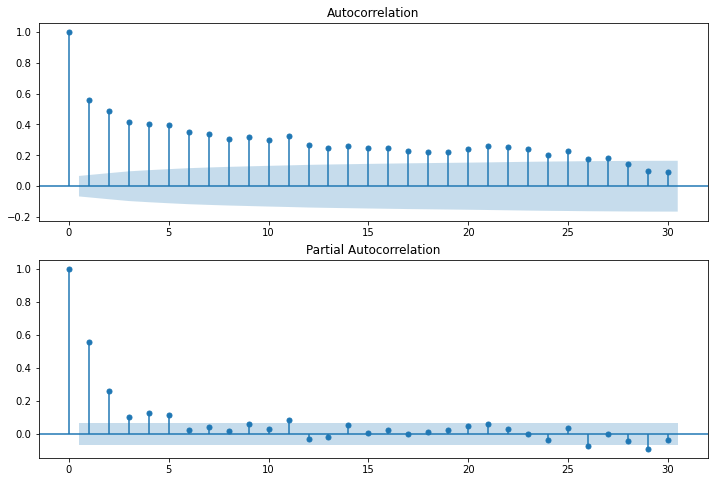

/home/bougoue/miniconda3/envs/waquapred-env/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


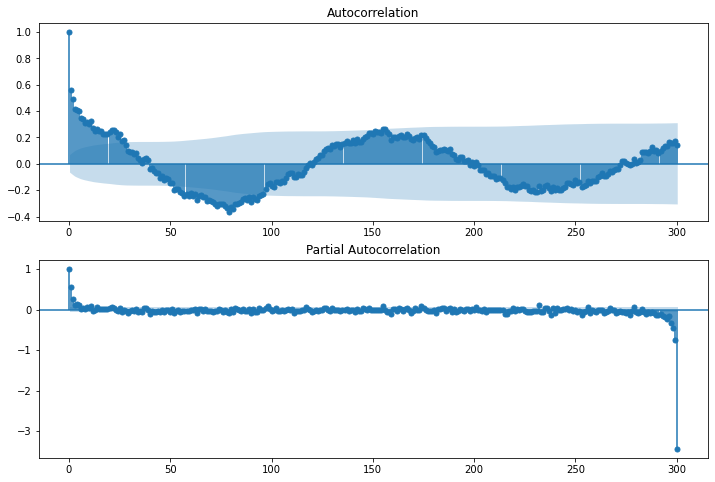

In [56]:
# Parameter Selection

fig, ax = plt.subplots(2, 1, figsize=(12,8))

plot_acf(df_train, lags=30, ax=ax[0])
plot_pacf(df_train, lags=30, ax=ax[1])

plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12,8))

plot_acf(df_train, lags=300, ax=ax[0])
plot_pacf(df_train, lags=300, ax=ax[1])

plt.show()

In [57]:
# Check mean count of observation for a year.

yearly_count = df_train.rolling('365D').count()[target_label].values
min_count = yearly_count[int(0.5*len(yearly_count)):].min()
mean_count = yearly_count[int(0.5*len(yearly_count)):].mean()
max_count = yearly_count[int(0.5*len(yearly_count)):].max()
print(min_count)
print(mean_count)
print(max_count)

154.0
158.3577981651376
165.0


In [58]:
# Optimize ARIMA model.

arima_model = pm.auto_arima(
    df_train.values,
    start_p=0,
    max_p=5,
    d=None,
    max_d=5,
    start_q=0,
    max_q=5,
    #m=158,
    #start_P=0,
    #max_P=5,
    seasonal=False,
    stationary=False,
    #D=None,
    #max_D=5,
    #start_Q=0,
    #max_Q=5,
    trace=True,
    max_order=None,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    trend=None
)

print(arima_model.summary())


with open(img_path + 'ARIMA/summary.csv', 'w') as outfile:
    outfile.write(arima_model.summary().as_csv())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5110.855, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2540.675, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4243.872, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2377.622, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2257.315, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2272.645, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2252.974, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2254.762, Time=0.53 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2260.845, Time=0.60 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2253.904, Time=0.27 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2255.310, Time=0.95 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2238.464, Time=0.98 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2

In [59]:
# Perform evaluation on training data.

n_start_samples = 100

arima_y_train = arima_model.predict_in_sample(start=n_start_samples)

y_train = df_train[:n_start_samples].values

naive_y_train = []
es_y_train = []
for y in tqdm(df_train[n_start_samples:].values):
    
    es_model = SimpleExpSmoothing(y_train).fit()
    #es_model = ExponentialSmoothing(y_train, seasonal_periods=158).fit()
    
    es_forecast = es_model.forecast(1)[0]

    naive_y_train.append(y_train[-1][0])
    es_y_train.append(es_forecast)

    y_train = np.append(y_train, [y], axis=0)


In [60]:
# Perform evaluation on test data.

y_train = df_train.values

y_test = []
naive_y_test = []
es_y_test = []
arima_y_test = []

for y in tqdm(df_test[target_label].values):
    
    es_model = SimpleExpSmoothing(y_train).fit()
    #es_model = ExponentialSmoothing(y_train, seasonal_periods=158).fit()
    
    es_forecast = es_model.forecast(1)[0]
    arima_forecast = arima_model.predict(1)[0]
    
    y_test.append(y)
    naive_y_test.append(y_train[-1][0])
    es_y_test.append(es_forecast)
    arima_y_test.append(arima_forecast)
    
    y_train = np.append(y_train, [[y]], axis=0)

    arima_model.update([[y]])
    

In [61]:
# Save Observations and Predictions.

y_train = df_train[n_start_samples:].values.ravel()

pd.DataFrame({
    'ds': train_dates[n_start_samples:],
    'observation': y_train,
    'prediction': naive_y_train
}).to_csv(
    img_path + 'Naive/train_predictions.csv',
    index=False
)

pd.DataFrame({
    'ds': test_dates,
    'observation': y_test,
    'prediction': naive_y_test
}).to_csv(
    img_path + 'Naive/test_predictions.csv',
    index=False
)

pd.DataFrame({
    'ds': train_dates[n_start_samples:],
    'observation': y_train,
    'prediction': es_y_train
}).to_csv(
    img_path + 'ExpSmooth/train_predictions.csv',
    index=False
)

pd.DataFrame({
    'ds': test_dates,
    'observation': y_test,
    'prediction': es_y_test
}).to_csv(
    img_path + 'ExpSmooth/test_predictions.csv',
    index=False
)

pd.DataFrame({
    'ds': train_dates[n_start_samples:],
    'observation': y_train,
    'prediction': arima_y_train
}).to_csv(
    img_path + 'ARIMA/train_predictions.csv',
    index=False
)

pd.DataFrame({
    'ds': test_dates,
    'observation': y_test,
    'prediction': arima_y_test
}).to_csv(
    img_path + 'ARIMA/test_predictions.csv',
    index=False
)

In [62]:
# Show Performance.

y_train = df_train[n_start_samples:].values.ravel()
naive_y_train = np.array(naive_y_train)
es_y_train = np.array(es_y_train)

naive_performance = obtain_performance('Naive', y_train, naive_y_train)
es_performance = obtain_performance('ExpSmooth', y_train, es_y_train)
arima_performance = obtain_performance('ARIMA', y_train, arima_y_train)

df_train_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_train_eval = df_train_eval.append(naive_performance, ignore_index=True)
df_train_eval = df_train_eval.append(es_performance, ignore_index=True)
df_train_eval = df_train_eval.append(arima_performance, ignore_index=True)

df_train_eval.to_csv(
    img_path + 'bl_train_metrics.csv',
    index=False
)

s = df_train_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

dfi.export(s, img_path + 'bl_train_metrics.png')

y_test = np.array(y_test)
naive_y_test = np.array(naive_y_test)
es_y_test = np.array(es_y_test)
arima_y_test = np.array(arima_y_test)

naive_performance = obtain_performance('Naive', y_test, naive_y_test)
es_performance = obtain_performance('ExpSmooth', y_test, es_y_test)
arima_performance = obtain_performance('ARIMA', y_test, arima_y_test)

df_test_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_test_eval = df_test_eval.append(naive_performance, ignore_index=True)
df_test_eval = df_test_eval.append(es_performance, ignore_index=True)
df_test_eval = df_test_eval.append(arima_performance, ignore_index=True)

df_test_eval.to_csv(
    img_path + 'bl_test_metrics.csv',
    index=False
)

s = df_test_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

dfi.export(s, img_path + 'bl_test_metrics.png')


Model,MAE,SMAPE,RMSE,R2
Naive,0.761861,19.759349,1.037591,0.149816
ExpSmooth,0.676324,16.888651,0.887311,0.378255
ARIMA,0.652402,16.280770,0.866024,0.407729


Model,MAE,SMAPE,RMSE,R2
Naive,0.730040,17.426626,0.978954,0.200474
ExpSmooth,0.638552,14.927614,0.817445,0.442526
ARIMA,0.642412,15.052122,0.808954,0.454047


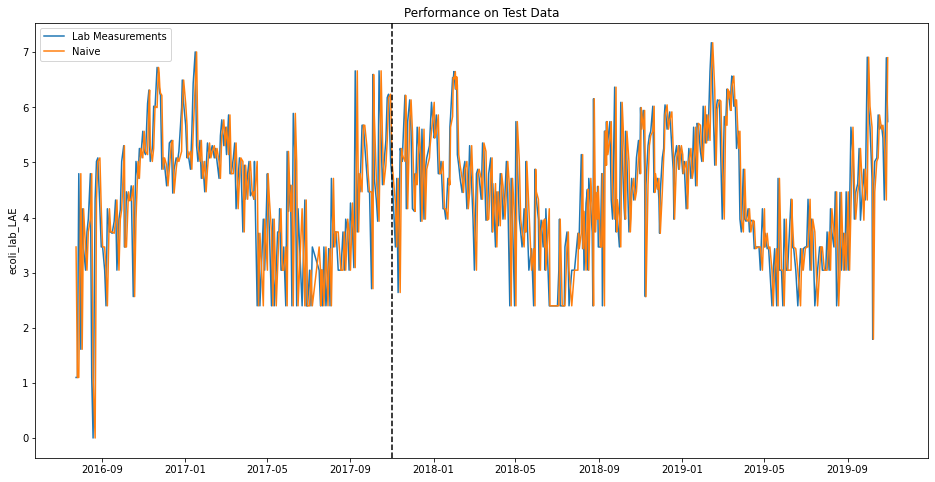

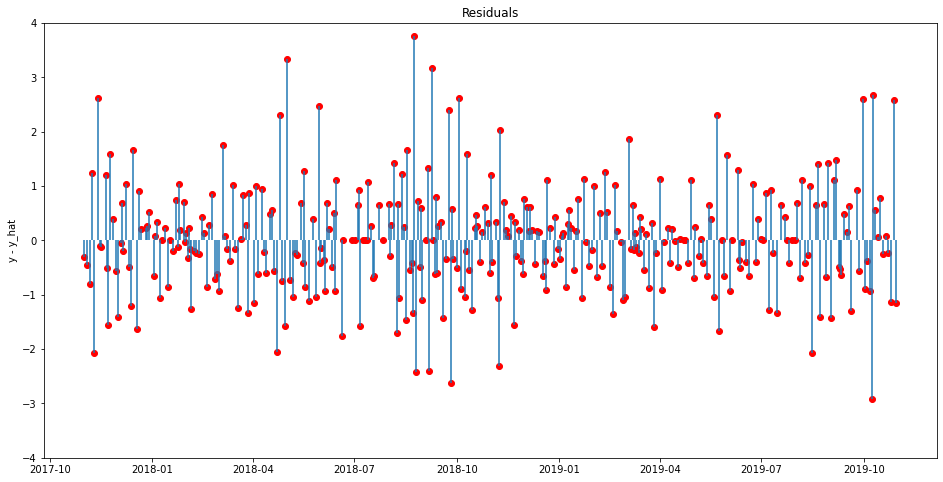

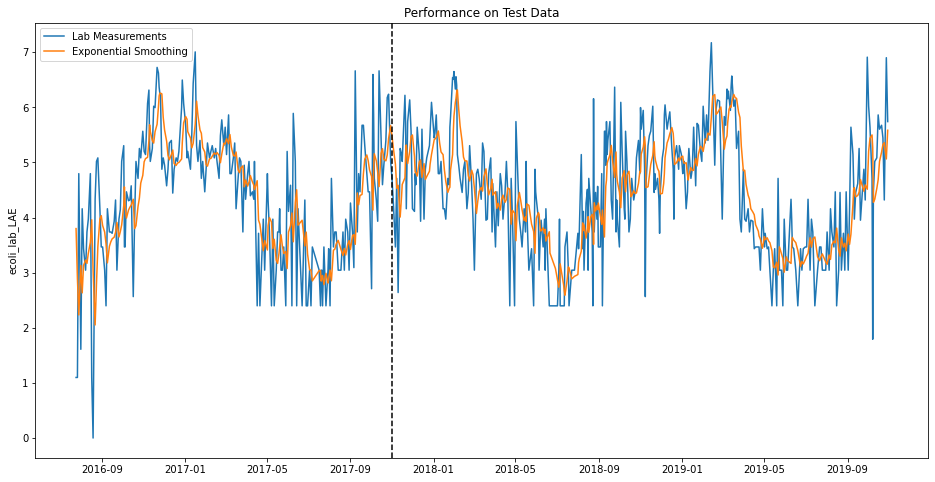

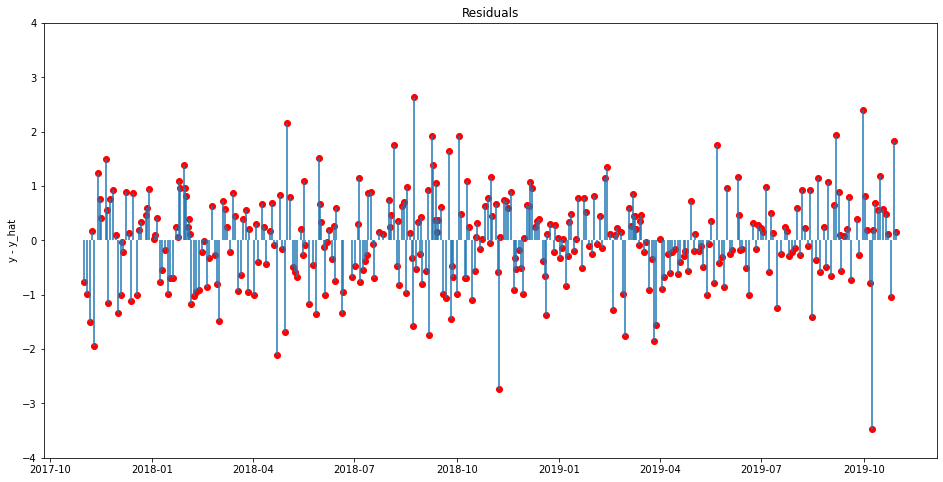

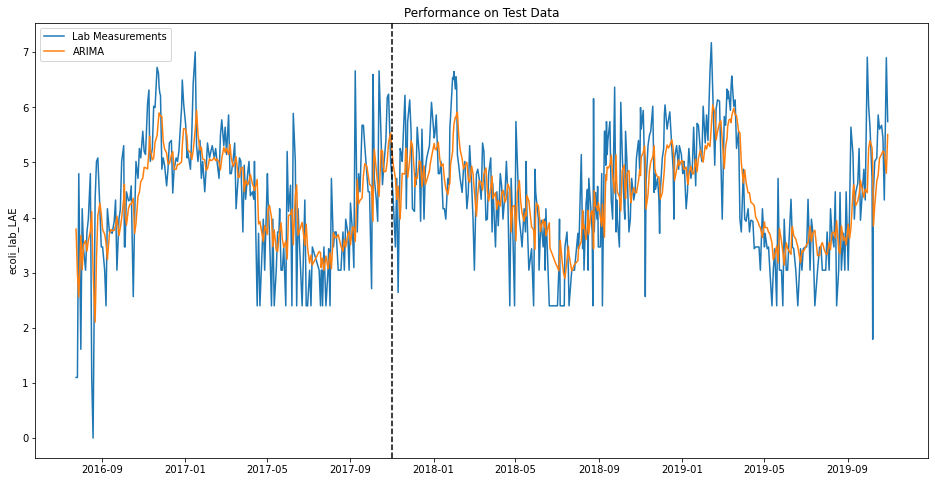

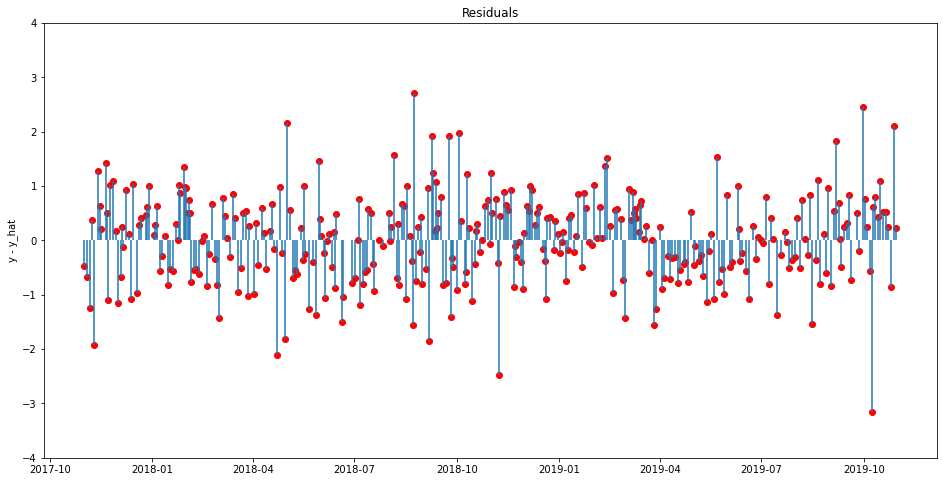

In [63]:
# Plot Performance.

n_train_dates = 200

y_min = -600
y_max = 1000
if log_scale_microbial_feats:
    y_min = -4
    y_max = 4

plt.figure(figsize=(16, 8), facecolor='w')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(y_train[-n_train_dates:], y_test), label='Lab Measurements')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(naive_y_train[-n_train_dates:], naive_y_test), label='Naive')
plt.ylabel(target_label)
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.title('Performance on Test Data')
plt.legend()
plt.savefig(img_path + 'Naive/test_plot.png', bbox_inches='tight', transparent=False)
plt.show()


plt.figure(figsize=(16, 8), facecolor='w')
plt.scatter(test_dates, y_test-naive_y_test, c='red')
plt.vlines(test_dates, 0.0, y_test-naive_y_test)
plt.ylabel('y - y_hat')
plt.ylim(y_min, y_max)
plt.title('Residuals')
plt.savefig(img_path + 'Naive/test_plot_residuals.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(16, 8), facecolor='w')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(y_train[-n_train_dates:], y_test), label='Lab Measurements')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(es_y_train[-n_train_dates:], es_y_test), label='Exponential Smoothing')
plt.ylabel(target_label)
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.title('Performance on Test Data')
plt.legend()
plt.savefig(img_path + 'ExpSmooth/test_plot.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(16, 8), facecolor='w')
plt.scatter(test_dates, y_test-es_y_test, c='red')
plt.vlines(test_dates, 0.0, y_test-es_y_test)
plt.ylabel('y - y_hat')
plt.ylim(y_min, y_max)
plt.title('Residuals')
plt.savefig(img_path + 'ExpSmooth/test_plot_residuals.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(16, 8), facecolor='w')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(y_train[-n_train_dates:], y_test), label='Lab Measurements')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(arima_y_train[-n_train_dates:], arima_y_test), label='ARIMA')
plt.ylabel(target_label)
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.title('Performance on Test Data')
plt.legend()
plt.savefig(img_path + 'ARIMA/test_plot.png', bbox_inches='tight', transparent=False)
plt.show()


plt.figure(figsize=(16, 8), facecolor='w')
plt.scatter(test_dates, y_test-arima_y_test, c='red')
plt.vlines(test_dates, 0.0, y_test-arima_y_test)
plt.ylabel('y - y_hat')
plt.ylim(y_min, y_max)
plt.title('Residuals')
plt.savefig(img_path + 'ARIMA/test_plot_residuals.png', bbox_inches='tight', transparent=False)
plt.show()


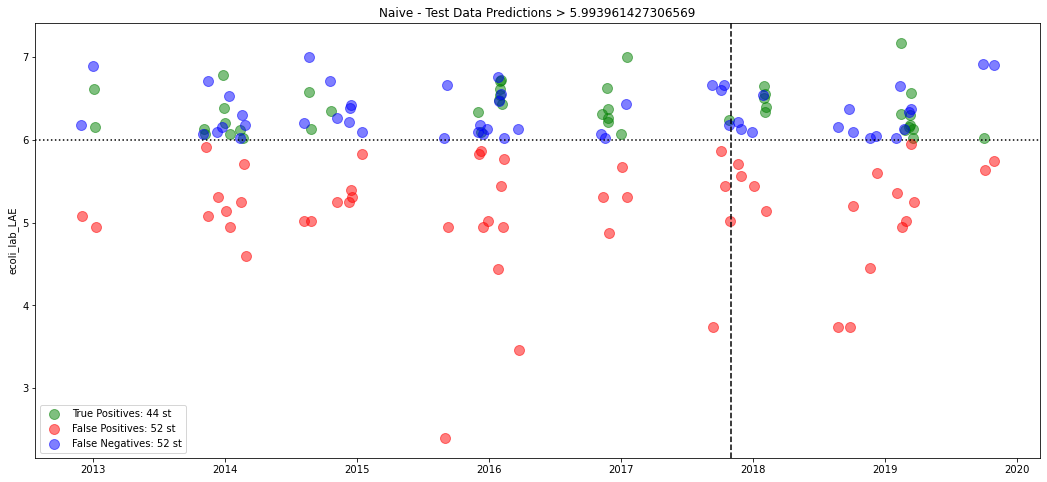

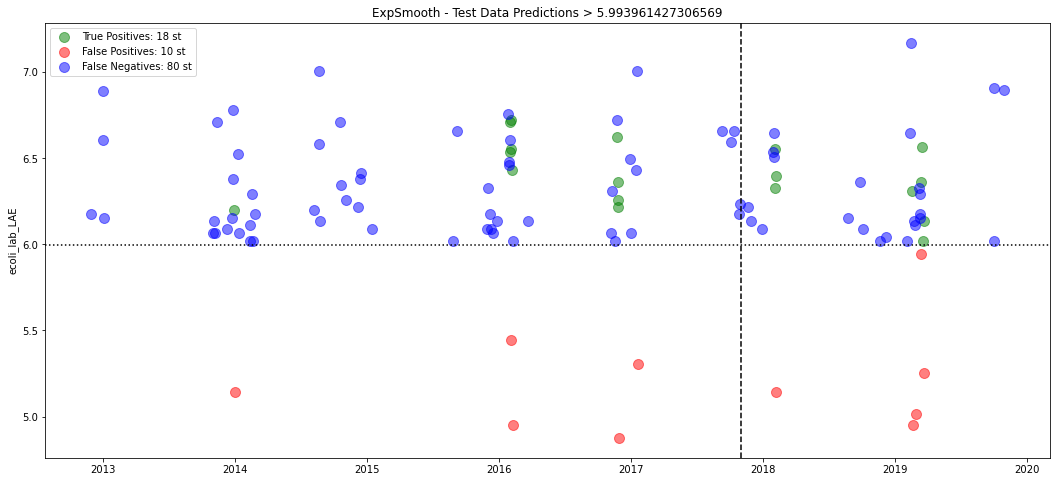

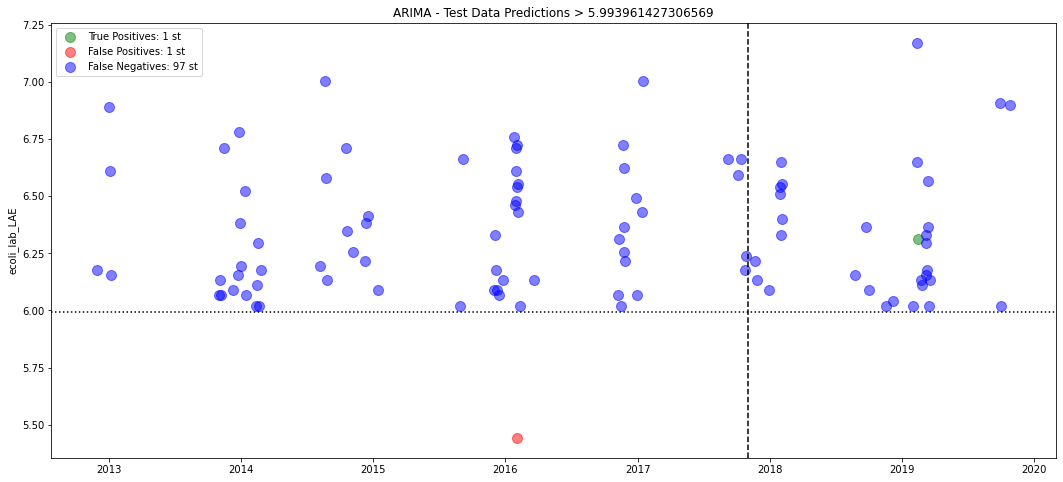

In [64]:
# Plot Performance on High Levels.

threshold = 400
if log_scale_microbial_feats:
    threshold = np.log1p(threshold)

y_merged = np.append(y_train, y_test)
y_merged_naive = np.append(naive_y_train, naive_y_test)
merged_dates = np.append(train_dates[n_start_samples:], test_dates)

tp_mask = (y_merged > threshold) * (y_merged_naive > threshold)
fp_mask = (y_merged < threshold) * (y_merged_naive > threshold)
fn_mask = (y_merged > threshold) * (y_merged_naive < threshold)

plt.figure(figsize=(18, 8), facecolor='w')
plt.scatter(merged_dates[tp_mask], y_merged[tp_mask], color='green', s=100, alpha=0.5, label='True Positives: ' + str(sum(tp_mask)) + ' st')
plt.scatter(merged_dates[fp_mask], y_merged[fp_mask], color='red', s=100, alpha=0.5, label='False Positives: ' + str(sum(fp_mask)) + ' st')
plt.scatter(merged_dates[fn_mask], y_merged[fn_mask], color='blue', s=100, alpha=0.5, label='False Negatives: ' + str(sum(fn_mask)) + ' st')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.axhline(y=threshold, color='black', linestyle='dotted')
plt.ylabel(target_label)
plt.title('Naive - Test Data Predictions > ' + str(threshold))
plt.legend()
plt.savefig(img_path + 'Naive/threshold_plot.png', bbox_inches='tight', transparent=False)
plt.show()

y_merged = np.append(y_train, y_test)
y_merged_es = np.append(es_y_train, es_y_test)
merged_dates = np.append(train_dates[n_start_samples:], test_dates)

tp_mask = (y_merged > threshold) * (y_merged_es > threshold)
fp_mask = (y_merged < threshold) * (y_merged_es > threshold)
fn_mask = (y_merged > threshold) * (y_merged_es < threshold)

plt.figure(figsize=(18, 8), facecolor='w')
plt.scatter(merged_dates[tp_mask], y_merged[tp_mask], color='green', s=100, alpha=0.5, label='True Positives: ' + str(sum(tp_mask)) + ' st')
plt.scatter(merged_dates[fp_mask], y_merged[fp_mask], color='red', s=100, alpha=0.5, label='False Positives: ' + str(sum(fp_mask)) + ' st')
plt.scatter(merged_dates[fn_mask], y_merged[fn_mask], color='blue', s=100, alpha=0.5, label='False Negatives: ' + str(sum(fn_mask)) + ' st')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.axhline(y=threshold, color='black', linestyle='dotted')
plt.ylabel(target_label)
plt.title('ExpSmooth - Test Data Predictions > ' + str(threshold))
plt.legend()
plt.savefig(img_path + 'ExpSmooth/threshold_plot.png', bbox_inches='tight', transparent=False)
plt.show()

y_merged = np.append(y_train, y_test)
y_merged_arima = np.append(arima_y_train, arima_y_test)
merged_dates = np.append(train_dates[n_start_samples:], test_dates)

tp_mask = (y_merged > threshold) * (y_merged_arima > threshold)
fp_mask = (y_merged < threshold) * (y_merged_arima > threshold)
fn_mask = (y_merged > threshold) * (y_merged_arima < threshold)

plt.figure(figsize=(18, 8), facecolor='w')
plt.scatter(merged_dates[tp_mask], y_merged[tp_mask], color='green', s=100, alpha=0.5, label='True Positives: ' + str(sum(tp_mask)) + ' st')
plt.scatter(merged_dates[fp_mask], y_merged[fp_mask], color='red', s=100, alpha=0.5, label='False Positives: ' + str(sum(fp_mask)) + ' st')
plt.scatter(merged_dates[fn_mask], y_merged[fn_mask], color='blue', s=100, alpha=0.5, label='False Negatives: ' + str(sum(fn_mask)) + ' st')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.axhline(y=threshold, color='black', linestyle='dotted')
plt.ylabel(target_label)
plt.title('ARIMA - Test Data Predictions > ' + str(threshold))
plt.legend()
plt.savefig(img_path + 'ARIMA/threshold_plot.png', bbox_inches='tight', transparent=False)
plt.show()


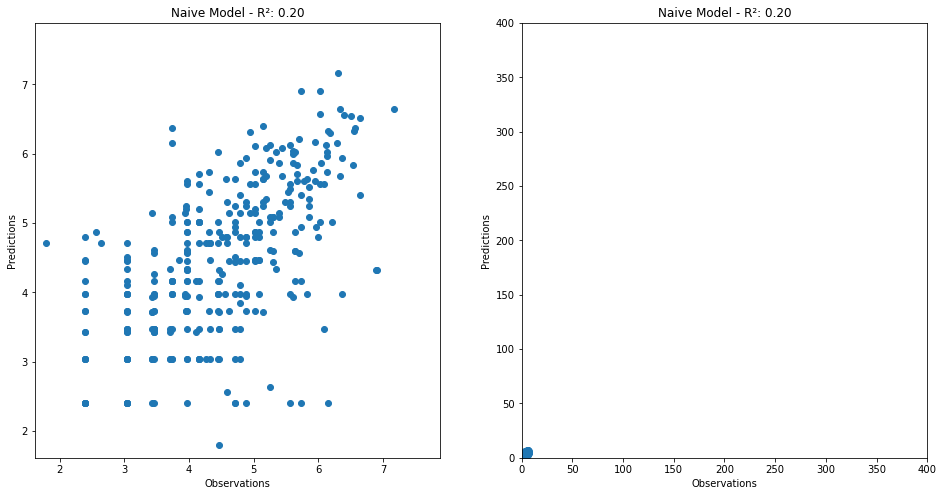

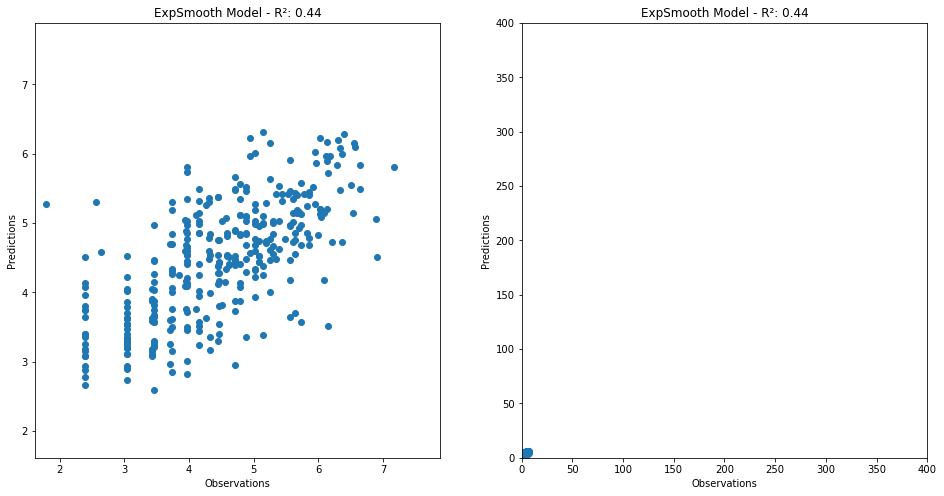

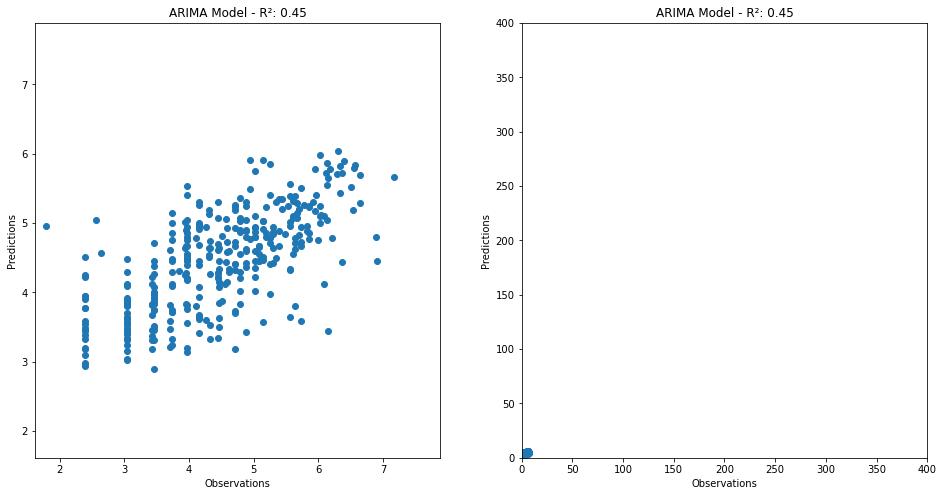

In [65]:
# Scatter Plots.

_axis_min = min(y_test) - 0.1*min(y_test)
_axis_max = max(y_test) + 0.1*max(y_test)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(y_test, naive_y_test)
plt.xlim(_axis_min, _axis_max)
plt.ylim(_axis_min, _axis_max)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Naive Model - R²: ' + '{:.2f}'.format(naive_performance['R2']))

plt.subplot(1, 2, 2)
plt.scatter(y_test, naive_y_test)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('Naive Model - R²: ' + '{:.2f}'.format(naive_performance['R2']))
plt.show()

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(y_test, es_y_test)
plt.xlim(_axis_min, _axis_max)
plt.ylim(_axis_min, _axis_max)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('ExpSmooth Model - R²: ' + '{:.2f}'.format(es_performance['R2']))

plt.subplot(1, 2, 2)
plt.scatter(y_test, es_y_test)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('ExpSmooth Model - R²: ' + '{:.2f}'.format(es_performance['R2']))
plt.show()

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(y_test, arima_y_test)
plt.xlim(_axis_min, _axis_max)
plt.ylim(_axis_min, _axis_max)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('ARIMA Model - R²: ' + '{:.2f}'.format(arima_performance['R2']))

plt.subplot(1, 2, 2)
plt.scatter(y_test, arima_y_test)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('ARIMA Model - R²: ' + '{:.2f}'.format(arima_performance['R2']))
plt.show()